# Machine Learning Models - Chad R. - Convolutional Neural Network and Classification of CIFAR-10 Set

## Convolutional Neural Network

In [1]:
# Import the Libraries
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision, torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time



In [2]:
# Set up CUDA so we don't have to wait 1:10 for the training to finish
torch.backends.cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, "| torch:", torch.__version__)

Device: cuda | torch: 2.6.0+cu124


In [3]:
# Augmentation and Normalization
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
])


In [4]:
#Splitting and setting up the different sets 
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
val_split = 5000
train_set_, val_set = torch.utils.data.random_split(train_set, [len(train_set)-val_split, val_split])
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(train_set_, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [5]:
# class for the model
class CIFARNet(nn.Module):
    def __init__(self, p_drop=0.4):
        super().__init__()
        def block(in_c, out_c, double=False):
            layers = [
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            if double:
                layers += [
                    nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool2d(2))  # downsample
            return nn.Sequential(*layers)
        self.features = nn.Sequential(
            block(3,   48, double=True),    # -> 16x16
            block(48,  96, double=True),    # -> 8x8
            block(96,  192, double=True),   # -> 4x4
            nn.Conv2d(192, 384, 3, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # 384 x 1 x 1
            nn.Flatten(),              # 384
            nn.Dropout(p_drop),
            nn.Linear(384, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CIFARNet(p_drop=0.4).to(device)

In [6]:
#Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params:,}")

#Training setup
epochs = 55  # less than 50
lr = 1e-3 # insanely small learning rate but it works well
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * y.size(0)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            count += y.size(0)
    return loss_sum / count, correct / count

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val = 0.0
start = time.time()


Total params: 1,512,026


In [7]:
# Training 
for ep in range(1, epochs+1):
    model.train()
    running_loss, correct, count = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
        count += y.size(0)
    train_loss = running_loss / count
    train_acc = correct / count
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_loss)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc);   val_accs.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "best_cifarnet.pt")

    print(f"Epoch {ep:02d}/{epochs} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc*100:.2f}% | "
          f"Val Loss {val_loss:.4f} Acc {val_acc*100:.2f}% | LR {optimizer.param_groups[0]['lr']:.2e}")

print("Training time (min):", (time.time()-start)/60.0)

Epoch 01/55 | Train Loss 1.4370 Acc 46.54% | Val Loss 1.1325 Acc 58.68% | LR 1.00e-03
Epoch 02/55 | Train Loss 1.0018 Acc 64.36% | Val Loss 1.0071 Acc 63.58% | LR 1.00e-03
Epoch 03/55 | Train Loss 0.8248 Acc 70.90% | Val Loss 0.7387 Acc 73.28% | LR 1.00e-03
Epoch 04/55 | Train Loss 0.7070 Acc 75.61% | Val Loss 0.7812 Acc 73.10% | LR 1.00e-03
Epoch 05/55 | Train Loss 0.6343 Acc 78.27% | Val Loss 0.6705 Acc 76.64% | LR 1.00e-03
Epoch 06/55 | Train Loss 0.5704 Acc 80.55% | Val Loss 0.6112 Acc 79.58% | LR 1.00e-03
Epoch 07/55 | Train Loss 0.5277 Acc 82.10% | Val Loss 0.5671 Acc 80.78% | LR 1.00e-03
Epoch 08/55 | Train Loss 0.4877 Acc 83.48% | Val Loss 0.5009 Acc 82.72% | LR 1.00e-03
Epoch 09/55 | Train Loss 0.4626 Acc 84.38% | Val Loss 0.5065 Acc 82.76% | LR 1.00e-03
Epoch 10/55 | Train Loss 0.4337 Acc 85.25% | Val Loss 0.4842 Acc 82.88% | LR 1.00e-03
Epoch 11/55 | Train Loss 0.4046 Acc 86.24% | Val Loss 0.4448 Acc 84.80% | LR 1.00e-03
Epoch 12/55 | Train Loss 0.3778 Acc 87.10% | Val Loss 

Final Test Top-1 Accuracy: 91.14%


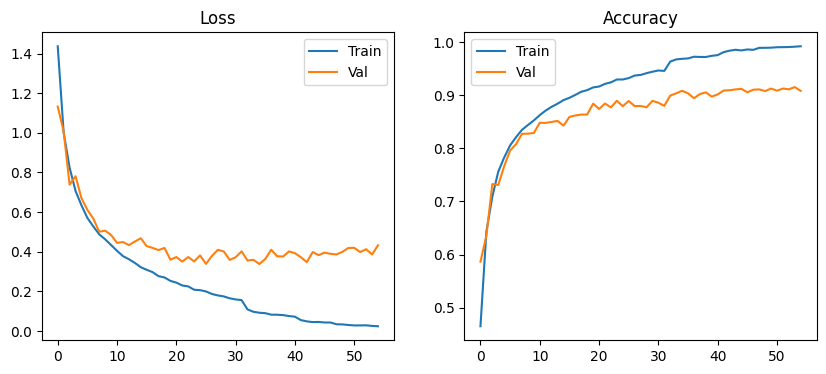

In [8]:
# Evaluate on test set
model.load_state_dict(torch.load("best_cifarnet.pt"))
test_loss, test_acc = evaluate(test_loader)
print(f"Final Test Top-1 Accuracy: {test_acc*100:.2f}%")

# Plot the curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.title("Accuracy"); plt.legend()
plt.show()

Batch normalization is needed because it normalizes the inputs of each layer, meaning that at each layer of the CNN the data is normalized for better results. Drop out is when we drop nodes so we do not have to deal with overfitting and so that more connections are considered since we can no longer consider just an individual one. Data augmentation improves performance by manipulating the data to avoid over fitting. 